## First Baseline model experiment using SPoC and epoched data (one subject)

This experiment notebook explain the process to generate the first baseline model on the public ECoG dataset.
A novel technique called Source Power Comodulation ([SPoC](https://mne.tools/dev/generated/mne.decoding.SPoC.html))
implemented in the MNE package  is used together with Ridge regression to predict the continuous output of a single
finger movement.

The SPoC algorithm has one main parameter, the number of new components it generates. This value has been calculated
empirically using cross-validation.

In [16]:
from utils import *

from mne.decoding import SPoC as SPoc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time

import matplotlib.pyplot as plt

In [17]:
# Variable that control if the model has to be trained (True) or imported (False).
set_train = False

In [18]:
# Set the data directory and sampling rate
data_dir = 'C:\\Users\\anellim1\Develop\Econ\BCICIV_4_mat\\'
file_name = 'sub1_comp.mat'
sampling_rate = 1000

figure_path = '..\Figures'
model_path = '..\Models'

The first step is to prepare the data in a the correct format. The MNE SPoC algorithm works with epoched data.
We filter the Y data in order to focus our analysis only on the thumb. We generate equally timed length epoch with sliding window.
Given the regression task and the that the sampling rate was 1000 hz, we decided to use a window duration of 0.5 and a
sliding factor of 0.25 such that we have a total number of original time points per epoch equal to 500.

In [19]:
X, y = import_ECoG(data_dir, file_name, 0)

print('Example of fingers position : {}'.format(y[0]))
print('epochs with events generation')
epochs = create_epoch(X, sampling_rate, duration=0.5, overlap=0.25, ds_factor=1)

The input data are of shape: (62, 400000), the corresponding y shape (filtered to 1 finger) is: (400000,)
Example of fingers position : -0.4001128575793339
epochs with events generation


In [20]:
X = epochs.get_data()
print(X.shape)

(1599, 62, 500)


Now that the input data are grouped in epochs, the Y has to be reshaped in order to have one output per epoch.
We are simply taking the mean of the 500 original time points.

In [21]:
y = y_resampling(y, X.shape[0])

Now we split the dataset in training and test set.

In [22]:
print('X shape {}, y shape {}'.format(X.shape, y.shape))

X_train, X_test, y_train, y_test = split_data(X, y, 0.3)

print('X_train shape {}, y_train shape {} \n X_test shape {}, y_test shape {}'
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X shape (1599, 62, 500), y shape (1599,)
X_train shape (1119, 62, 500), y_train shape (1119,) 
 X_test shape (480, 62, 500), y_test shape (480,)


After the slit of the dataset the we train the model. First, we generate a Pipeline with the SPoC model and the Ridge Linear Regression.
Than we train different pipeline tuning the n_components of the SPoC algorithm.

In [23]:
if set_train:
    pipeline = Pipeline([('Spoc', SPoc(log=True, reg='oas', rank='full')),
                    ('Ridge', Ridge())])

# tuned_parameters = [{'Spoc__n_components': list(np.arange(2, 5))}]
    cv = KFold(n_splits=10, shuffle=False)
    tuned_parameters = [{'Spoc__n_components': list(map(int, list(np.arange(2, 21))))}]

    model = GridSearchCV(pipeline, tuned_parameters, scoring= 'neg_mean_squared_error', n_jobs=-1, cv=cv)

    start = time.time()
    print('Start Fitting model ...')
    model.fit(X_train, y_train)

    print(f'Training time : {time.time() - start}s ')
    print('Number of cross-validation splits folds/iteration: {}'.format(model.n_splits_))
    print('Best Score and parameter combination: ')
    print(model.best_score_)
    print(model.best_params_)
    save_skl_model(model, model_path, 'BaselineModel_SPoC_Best.p')
else:
    if not os.path.exists(os.path.join(model_path, 'BaselineModel_SPoC_Best.p')):
        print('Model does not exist, consider to set the set_train variable to True')
    else:
        model = load_skl_model(os.path.join(model_path, 'BaselineModel_SPoC_Best.p'))
        print('Number of cross-validation splits folds/iteration: {}'.format(model.n_splits_))
        print('Best Score and parameter combination: ')
        print(model.best_score_)
        print(model.best_params_)

Model loaded successfully.
Number of cross-validation splits folds/iteration: 10
Best Score and parameter combination: 
-0.43154552104921173
{'Spoc__n_components': 10}


Following a plot that summarise the n_component parameter selection.

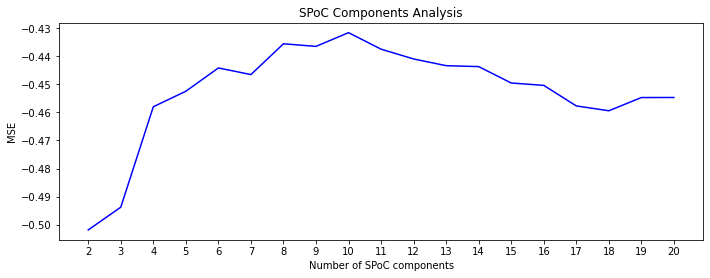

In [24]:
n_components = np.ma.getdata(model.cv_results_['param_Spoc__n_components'])
MSEs = model.cv_results_['mean_test_score']

fig, ax = plt.subplots(1, 1, figsize=[10, 4])
ax.plot(n_components, MSEs, color='b')
ax.set_xlabel('Number of SPoC components')
ax.set_ylabel('MSE')
ax.set_title('SPoC Components Analysis')
# plt.legend()
plt.xticks(n_components, n_components)
mne.viz.tight_layout()
plt.savefig(os.path.join(figure_path, 'SPoC_Components_Analysis.pdf'))
plt.show()

Now that the model is fitted and we know the best parameter, we can predict the y_pred. And calculate the MSE and MAE
on the test set of the best model.

In [25]:
y_pred = model.predict(X_test)
print('mean squared error {}'.format(mean_squared_error(y_test, y_pred)))
print('mean absolute error {}'.format(mean_absolute_error(y_test, y_pred)))

mean squared error 0.43242467435216414
mean absolute error 0.41360400007530157


Plot the y predicted respect to the true y.

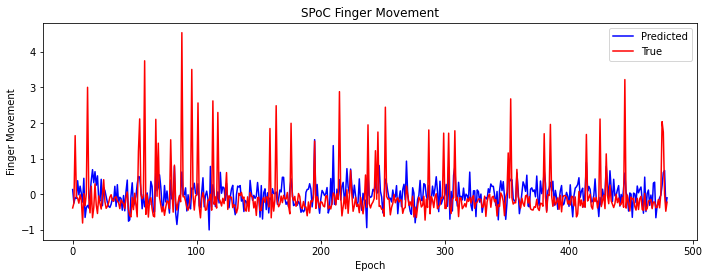

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[10, 4])
times = np.arange(y_pred.shape[0])
ax.plot(times, y_pred, color='b', label='Predicted')
ax.plot(times, y_test, color='r', label='True')
ax.set_xlabel('Epoch')
ax.set_ylabel('Finger Movement')
ax.set_title('SPoC Finger Movement')
plt.legend()
mne.viz.tight_layout()
plt.savefig(os.path.join(figure_path, 'SPoC_Finger_Prediction.pdf'))
plt.show()

In [27]:
# mne.set_log_level(verbose='WARNING')
mne.set_config('MNE_LOGGING_LEVEL', 'WARNING')
print(mne.get_config('MNE_LOGGING_LEVEL'))

WARNING
